In [39]:
# Add this at the beginning of your code (before dataset initialization)
import os
import requests
import zipfile

def download_div2k():
    os.makedirs("/content/DIV2K", exist_ok=True)

    # Download DIV2K train dataset (HR images)
    if not os.path.exists("/content/DIV2K/DIV2K_train_HR"):
        print("Downloading DIV2K dataset...")
        url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
        r = requests.get(url, stream=True)
        with open("/content/DIV2K/train_hr.zip", "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)

        print("Extracting...")
        with zipfile.ZipFile("/content/DIV2K/train_hr.zip", 'r') as zip_ref:
            zip_ref.extractall("/content/DIV2K")
        os.remove("/content/DIV2K/train_hr.zip")

    # Download DIV2K validation dataset (HR images)
    if not os.path.exists("/content/DIV2K/DIV2K_valid_HR"):
        print("Downloading DIV2K validation set...")
        url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip"
        r = requests.get(url, stream=True)
        with open("/content/DIV2K/valid_hr.zip", "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)

        print("Extracting...")
        with zipfile.ZipFile("/content/DIV2K/valid_hr.zip", 'r') as zip_ref:
            zip_ref.extractall("/content/DIV2K")
        os.remove("/content/DIV2K/valid_hr.zip")

# Download the dataset before creating the dataset object
download_div2k()

Extracting...
Extracting...


Epoch 1/5: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 1: Avg Loss = 0.3246


Epoch 2/5: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Epoch 2: Avg Loss = 0.2467


Epoch 3/5: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 3: Avg Loss = 0.2061


Epoch 4/5: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 4: Avg Loss = 0.2063


Epoch 5/5: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 5: Avg Loss = 0.1796
Model saved to: /content/swinir_div2k.pth
PSNR: 17.87 dB
SSIM: 0.5048


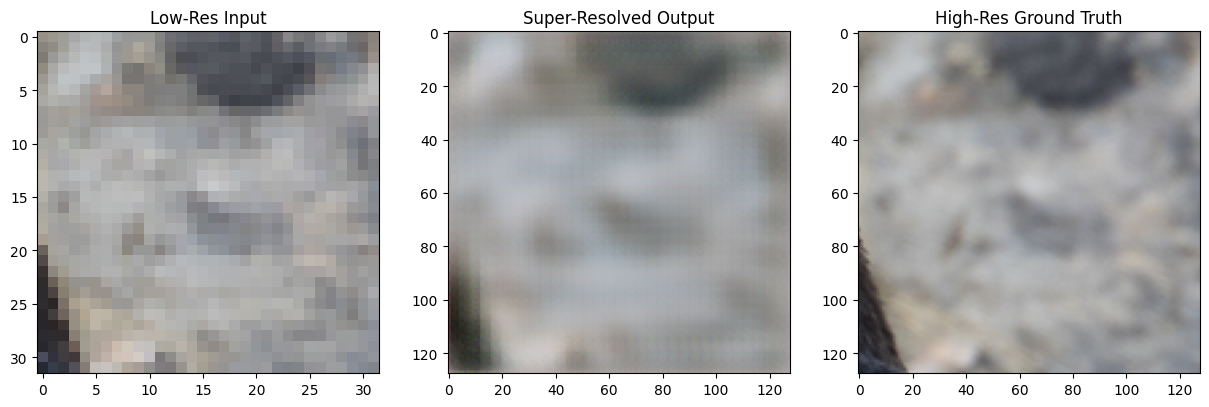

In [17]:
# 1. Import Libraries
import os
import math
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# 2. Dataset Loader (DIV2K)
class DIV2KDataset(Dataset):
    def __init__(self, hr_size=128, scale=4, train=True):
        self.hr_path = "/content/DIV2K/DIV2K_train_HR" if train else "/content/DIV2K/DIV2K_valid_HR"
        self.hr_size = hr_size
        self.scale = scale
        self.image_files = sorted([f for f in os.listdir(self.hr_path) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.hr_path, self.image_files[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        top = np.random.randint(0, h - self.hr_size)
        left = np.random.randint(0, w - self.hr_size)
        hr_img = img[top:top+self.hr_size, left:left+self.hr_size]
        lr_img = cv2.resize(hr_img, (self.hr_size // self.scale, self.hr_size // self.scale), interpolation=cv2.INTER_CUBIC)

        hr_img = torch.tensor(hr_img / 127.5 - 1).permute(2, 0, 1).float()
        lr_img = torch.tensor(lr_img / 127.5 - 1).permute(2, 0, 1).float()
        return {'lr': lr_img, 'hr': hr_img}

# 3. SwinIR-like Model (Simplified)
class SwinIR(nn.Module):
    def __init__(self, in_chans=3, embed_dim=64, depths=4, upscale=4):
        super(SwinIR, self).__init__()

        self.mean = torch.Tensor([0.4488, 0.4371, 0.4040]).view(1, 3, 1, 1)
        self.upscale = upscale

        self.conv_first = nn.Conv2d(in_chans, embed_dim, 3, 1, 1)

        # Deep feature extractor
        layers = []
        for _ in range(depths):
            layers.append(nn.Sequential(
                nn.Conv2d(embed_dim, embed_dim, 3, 1, 1),
                nn.BatchNorm2d(embed_dim),
                nn.ReLU(inplace=True)
            ))
        self.layers = nn.Sequential(*layers)

        self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)

        # Upsampling
        self.upsample = self.build_upsample(upscale, embed_dim)
        self.conv_last = nn.Conv2d(embed_dim, in_chans, 3, 1, 1)

    def build_upsample(self, scale, num_feat):
        layers = []
        if (scale & (scale - 1)) == 0:
            for _ in range(int(math.log(scale, 2))):
                layers.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                layers.append(nn.PixelShuffle(2))
                layers.append(nn.ReLU(inplace=True))
        elif scale == 3:
            layers.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            layers.append(nn.PixelShuffle(3))
            layers.append(nn.ReLU(inplace=True))
        else:
            raise ValueError(f"Unsupported upscale: {scale}")
        return nn.Sequential(*layers)

    def forward(self, x):
        self.mean = self.mean.to(x.device)
        x = x - self.mean

        x = self.conv_first(x)
        x = self.layers(x)
        x = self.conv_after_body(x)
        x = self.upsample(x)
        x = self.conv_last(x)

        x = x + self.mean
        return x

# 4. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = DIV2KDataset(train=True)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = SwinIR().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
save_path = "/content/swinir_div2k.pth"

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)

        sr = model(lr)
        loss = criterion(sr, hr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(dataloader):.4f}")

# 5. Save Model
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

# 6. Load Model
model.load_state_dict(torch.load(save_path))
model.eval()

# 7. Evaluation Metrics
def evaluate_metrics(model, dataset, num_samples=5):
    psnr_vals, ssim_vals = [], []
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            lr = sample['lr'].unsqueeze(0).to(device)
            hr = sample['hr'].permute(1, 2, 0).numpy()
            sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()

            hr = ((hr + 1) * 127.5).astype(np.uint8)
            sr = ((sr + 1) * 127.5).astype(np.uint8)

            psnr_vals.append(psnr_metric(hr, sr, data_range=255))
            ssim_vals.append(ssim_metric(hr, sr, channel_axis=-1))

    print(f"PSNR: {np.mean(psnr_vals):.2f} dB")
    print(f"SSIM: {np.mean(ssim_vals):.4f}")

# 8. Visualize Result
def show_sr_result(model, dataset, idx=0):
    with torch.no_grad():
        sample = dataset[idx]
        lr = sample['lr'].unsqueeze(0).to(device)
        sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()
        hr = sample['hr'].permute(1, 2, 0).numpy()
        lr = sample['lr'].permute(1, 2, 0).numpy()

        sr = (sr + 1) * 127.5
        hr = (hr + 1) * 127.5
        lr = (lr + 1) * 127.5

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(lr.astype(np.uint8))
        plt.title("Low-Res Input")
        plt.subplot(1, 3, 2)
        plt.imshow(sr.astype(np.uint8))
        plt.title("Super-Resolved Output")
        plt.subplot(1, 3, 3)
        plt.imshow(hr.astype(np.uint8))
        plt.title("High-Res Ground Truth")
        plt.show()

# Run evaluation
val_dataset = DIV2KDataset(train=False)
evaluate_metrics(model, val_dataset, num_samples=10)
show_sr_result(model, val_dataset, idx=0)


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
